In [1]:
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda:0


In [2]:
X_dim = 6
c_dim = 21
gridSize = 11
z_dim = 3

bs = 256

In [3]:
from data.NarrowPassDataset import NarrowPassCnnDataset

train_loader = DataLoader(NarrowPassCnnDataset(csv_file = "data/NarrowPassage/narrowDataOcc.txt",
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            gridSize = gridSize,
                            train = True),
                         batch_size = bs, shuffle=True)
test_loader = DataLoader(NarrowPassCnnDataset(csv_file = "data/NarrowPassage/narrowDataOcc.txt",
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            gridSize = gridSize,
                            train = False), 
                         batch_size = bs, shuffle=True)

In [4]:
import torch.nn.functional as F
class convVAE(nn.Module):
    def __init__(self, sample_size, grid_size, cnnout_size, encoder_layer_sizes, latent_size, decoder_layer_sizes):
        super(convVAE, self).__init__()

        assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list
        
        self.latent_size = latent_size
        self.condnn = CondNN(sample_size, grid_size, cnnout_size)
        self.encoder = Encoder(sample_size + cnnout_size, encoder_layer_sizes, latent_size)
        self.decoder = Decoder(latent_size + cnnout_size, decoder_layer_sizes, sample_size)

    def cnn(self,startend, occ):
        return self.cnn(startend, occ)
        
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, startend, occ):
        c = self.condnn(startend, occ)
        mu, logvar = self.encode(torch.cat((x, c), dim=-1))
        z = self.reparameterize(mu, logvar)
        return self.decode(torch.cat((z, c), dim=-1)), mu, logvar
    
    def inference(self, startend, occ, num_viz):
        c = self.condnn(startend, occ)
        z = torch.randn(num_viz, self.latent_size, device = c.device)
        return self.decode(torch.cat((z, c), dim=-1))
    
class Encoder(nn.Module):
    def __init__(self, input_size, layer_sizes, latent_size):
        super(Encoder, self).__init__()

        layer_sizes = [input_size] + layer_sizes
        modules = []
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=0.5))

        self.sequential = nn.Sequential(*modules)
        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x):
        x = self.sequential(x)
        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)
        return means, log_vars


class Decoder(nn.Module):
    def __init__(self, input_size, layer_sizes, sample_size):
        super(Decoder, self).__init__()

        layer_sizes = [input_size] + layer_sizes
        modules = []
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=0.5))
        modules.append(nn.Linear(layer_sizes[-1], sample_size))

        self.sequential = nn.Sequential(*modules)

    def forward(self, x):
        return self.sequential(x)


class CondNN(nn.Module):
    def __init__(self, sampleSize, gridSize, outSize):
        super(CondNN, self).__init__()
        self.sampleSize = sampleSize
        self.gridSize = gridSize
        self.conv1 = nn.Conv2d(1, 6, 3, padding=(1,1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 3 * 3, 40)
        self.fc2 = nn.Linear(40 + sampleSize * 2, outSize)

    def forward(self, startend, occ):
        occ = self.pool(F.relu(self.conv1(occ)))
        occ = F.relu(self.conv2(occ))
        occ = occ.view(-1, 16 * 3 * 3)
        occ = F.relu(self.fc1(occ))
        x = torch.cat((occ, startend), dim=-1)
        x = F.relu(self.fc2(x))
        return x


In [5]:
model = convVAE(sample_size = X_dim, 
                  grid_size = gridSize, 
                  cnnout_size = 30,
                  encoder_layer_sizes = [512,1024,512], 
                  latent_size = z_dim, 
                  decoder_layer_sizes = [512,1024,512]).to(device)
print(model)

convVAE(
  (condnn): CondNN(
    (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (fc1): Linear(in_features=144, out_features=40, bias=True)
    (fc2): Linear(in_features=52, out_features=30, bias=True)
  )
  (encoder): Encoder(
    (sequential): Sequential(
      (0): Linear(in_features=36, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5)
      (3): Linear(in_features=512, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.5)
      (6): Linear(in_features=1024, out_features=512, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.5)
    )
    (linear_means): Linear(in_features=512, out_features=3, bias=True)
    (linear_log_var): Linear(in_features=512, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (sequential): Sequential(
      (0): Linear(in_features=33,

In [6]:
def loss_fn(recon_x, x, w, mean, log_var):
    MSE = torch.mean((w.expand_as(x) * (recon_x-x)**2))
    KLD = - 0.002 * torch.mean(torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), 1))
    return MSE + KLD, MSE

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def train(epoch):
    model.train()
    train_loss = 0
    mse_loss = 0
    w = torch.tensor([1, 1, 1, 0.5, 0.5, 0.5], dtype=torch.float).to(device)
    for batch_idx, (sample, _, startend, occ) in enumerate(train_loader):
        
        sample, startend, occ = sample.to(device), startend.to(device), occ.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(sample, startend, occ)
        loss, mse= loss_fn(recon_batch, sample, w, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        mse_loss += mse.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(sample), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))

    epoch_loss = train_loss * len(sample) / len(train_loader.dataset)
    epoch_mse = mse_loss * len(sample) / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.7f}'.format(
          epoch, epoch_loss))
    return epoch, epoch_loss, epoch_mse

def test(epoch):
    model.eval()
    test_loss = 0
    mse_loss = 0
    w = torch.tensor([1, 1, 1, 0.5, 0.5, 0.5], dtype=torch.float).to(device)
    for batch_idx, (sample, _, startend, occ) in enumerate(test_loader):
        
        sample, startend, occ = sample.to(device), startend.to(device), occ.to(device)
        recon_batch, mu, logvar = model(sample, startend, occ)
        loss, mse= loss_fn(recon_batch, sample, w, mu, logvar)
        test_loss += loss.item()
        mse_loss += mse.item()

    epoch_loss = test_loss * len(sample) / len(test_loader.dataset)
    epoch_mse = mse_loss * len(sample) / len(test_loader.dataset)
    print('====> Epoch: {} Average test loss: {:.7f}'.format(
          epoch, epoch_loss))
    return epoch, epoch_loss, epoch_mse

In [8]:
epoch = 0
from visdom import Visdom
vis = Visdom(env='cnn_0.02')

loss_window = vis.line(
    Y=torch.zeros((1)).cpu(),
    X=torch.zeros((1)).cpu(),
    opts=dict(xlabel='epoch',ylabel='Loss',title='training loss',legend=['loss']))

In [9]:
for epoch in range(epoch, epoch + 600):
    log_interval = 100
    epoch, epoch_loss, epoch_mse = train(epoch)
    vis.line(X=torch.ones((1,1)).cpu()*epoch,Y=torch.Tensor([epoch_loss]).unsqueeze(0).cpu(),win=loss_window,update='append',name='loss')
    vis.line(X=torch.ones((1,1)).cpu()*epoch,Y=torch.Tensor([epoch_mse]).unsqueeze(0).cpu(),win=loss_window,update='append',name='mse_loss')
    

Train Epoch: 0 [0/66984 (0%)]	Loss: 0.281534
Train Epoch: 0 [25600/66984 (38%)]	Loss: 0.067009
Train Epoch: 0 [51200/66984 (76%)]	Loss: 0.052604
====> Epoch: 0 Average loss: 0.0484445
Train Epoch: 1 [0/66984 (0%)]	Loss: 0.052168
Train Epoch: 1 [25600/66984 (38%)]	Loss: 0.048450
Train Epoch: 1 [51200/66984 (76%)]	Loss: 0.048225
====> Epoch: 1 Average loss: 0.0323815
Train Epoch: 2 [0/66984 (0%)]	Loss: 0.045488
Train Epoch: 2 [25600/66984 (38%)]	Loss: 0.045008
Train Epoch: 2 [51200/66984 (76%)]	Loss: 0.043264
====> Epoch: 2 Average loss: 0.0295890
Train Epoch: 3 [0/66984 (0%)]	Loss: 0.045140
Train Epoch: 3 [25600/66984 (38%)]	Loss: 0.042951
Train Epoch: 3 [51200/66984 (76%)]	Loss: 0.039441
====> Epoch: 3 Average loss: 0.0272384
Train Epoch: 4 [0/66984 (0%)]	Loss: 0.041703
Train Epoch: 4 [25600/66984 (38%)]	Loss: 0.040632
Train Epoch: 4 [51200/66984 (76%)]	Loss: 0.039216
====> Epoch: 4 Average loss: 0.0259949
Train Epoch: 5 [0/66984 (0%)]	Loss: 0.040482
Train Epoch: 5 [25600/66984 (38%)]	

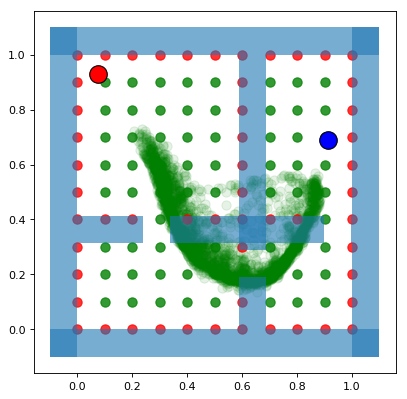

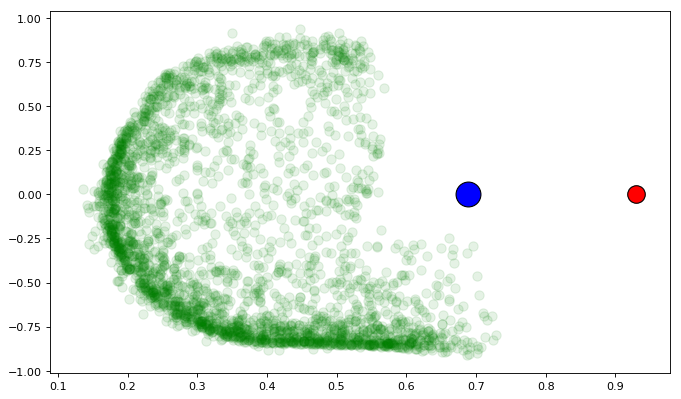

In [25]:
test_data = test_loader.dataset
viz_idx =   torch.randint(0,len(test_data),[1]).item()  

viz_idx = 8712

_, con, startend, occ = test_data[viz_idx]
startend, occ = torch.tensor(startend), torch.unsqueeze(torch.tensor(occ), 0)
model.eval()
num_viz = 3000
y_viz = model.inference(startend.expand(num_viz, -1).to(device), 
                        occ.expand(num_viz, -1, -1, -1).to(device), num_viz)

y_viz=y_viz.cpu().detach().numpy()
occ=occ.cpu().detach().numpy()

from utils.NarrowPassage import plotCondition, plotSample, plotSpeed

# plotCondition(condition)
plotSample(y_viz, con)
plotSpeed(y_viz, con)

In [16]:
occ.shape

torch.Size([1, 1, 11, 11])

In [19]:
occ.expand(10,-1,-1,-1).shape

torch.Size([10, 1, 11, 11])